# 1. Problemin Tanımı
Bu çalışma, bir şirketin geçmiş hisse fiyat verilerini veya kurun kullanarak gelecekteki fiyatını tahmin etmeyi amaçlar. LSTM tabanlı bir model kullanılacaktır.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (16, 9)

# 2. Veri Yükleme ve İnceleme (EDA)

İlk 5 Satır:
  Date     Adj Close         Close          High           Low          Open  \
0  NaT  65173.195312  65173.195312  65255.261719  65039.734375  65179.914062   
1  NaT  65053.859375  65053.859375  65178.386719  65043.246094  65156.187500   
2  NaT  64886.878906  64886.878906  65111.453125  64853.480469  65058.765625   
3  NaT  64841.109375  64841.109375  65071.031250  64799.878906  64924.093750   
4  NaT  64921.792969  64921.792969  65046.050781  64797.417969  64889.031250   

   Volume  
0       0  
1       0  
2       0  
3       0  
4       0  

Veri Boyutu: (4393, 7)

Veri Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       0 non-null      datetime64[ns]
 1   Adj Close  4393 non-null   float64       
 2   Close      4393 non-null   float64       
 3   High       4393 non-null   float64       
 4   Lo

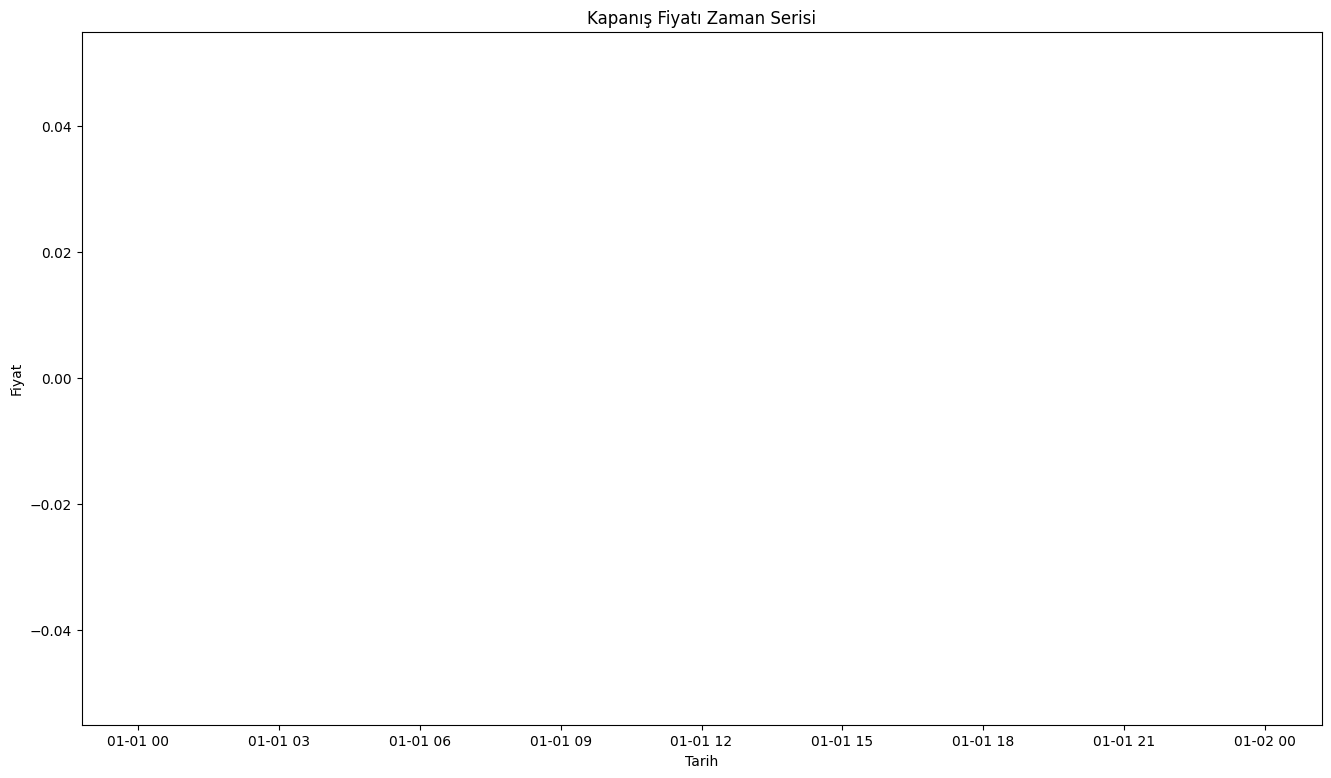


İstatistiksel Özellikler:
count      4393.000000
mean      69975.487912
std       14519.861360
min       49842.523438
25%       60250.726562
50%       64119.046875
75%       71126.015625
max      108240.085938
Name: Close, dtype: float64


In [2]:
file_path = 'BTCUSD_stock_data.csv'  # Dosya yolunuzu belirtin.
df = pd.read_csv(file_path)

# Tarihi datetime formata çevir
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Tarihe göre sırala
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# Veri önizleme
print("İlk 5 Satır:")
print(df.head())
print("\nVeri Boyutu:", df.shape)
print("\nVeri Bilgisi:")
print(df.info())
print("\nEksik Veri Sayısı:")
print(df.isnull().sum())

# Fiyat zaman serisi grafiği
plt.title("Kapanış Fiyatı Zaman Serisi")
plt.plot(df['Date'], df['Close'])
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.show()

print("\nİstatistiksel Özellikler:")
print(df['Close'].describe())

# 3. Ön İşleme (Data Preprocessing)
Eksik değer yok varsayımıyla devam ediyoruz.
Sadece 'Close' sütununu kullanacağız.

In [3]:
for i in range(1, len(df['Close']) - 1):
    if np.isnan(df['Close'][i]):
        df.loc[i, 'Close'] = np.nanmean([df['Close'][i - 1], df['Close'][i + 1]])

fiyat = df['Close'].values.reshape(-1, 1)

# 4. Feature Engineering (Özellik Mühendisliği)
Ekstra özellik eklemiyoruz.

In [4]:
# Ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(fiyat)

def dataset_olustur(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100

# 5. Eğitim-Test Ayrımı (Train-Test Split)

In [5]:
train_size = int(len(scaled_prices) * 0.8)
test_size = len(scaled_prices) - train_size
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

X_train, y_train = dataset_olustur(train_data, time_step)
X_test, y_test = dataset_olustur(test_data, time_step)

# LSTM girişi 3 boyutlu: [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Eğitim veri boyutu:", X_train.shape, y_train.shape)
print("Test veri boyutu:", X_test.shape, y_test.shape)

Eğitim veri boyutu: (3413, 100, 1) (3413,)
Test veri boyutu: (778, 100, 1) (778,)


# 6. Model Kurulumu

In [6]:
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model()

c:\Users\ylmz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 7. Model Eğitimi ve Doğrulaması (Validation)
EarlyStopping ile durdurma. Burada patience=5 kullanıyoruz.

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - loss: 0.0039 - val_loss: 7.8694e-04
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 7.2945e-04 - val_loss: 0.0019
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - loss: 4.1855e-04 - val_loss: 5.7286e-04
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 3.3887e-04 - val_loss: 4.8606e-04
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - loss: 4.3069e-04 - val_loss: 2.3533e-04
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - loss: 2.6212e-04 - val_loss: 3.2133e-04
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - loss: 2.1340e-04 - val_loss: 1.9280e-04
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - loss: 2.3571e-04 - val_loss: 6.1383e-04
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - loss: 1.9878e-04 - val_loss: 0.0046
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - lo

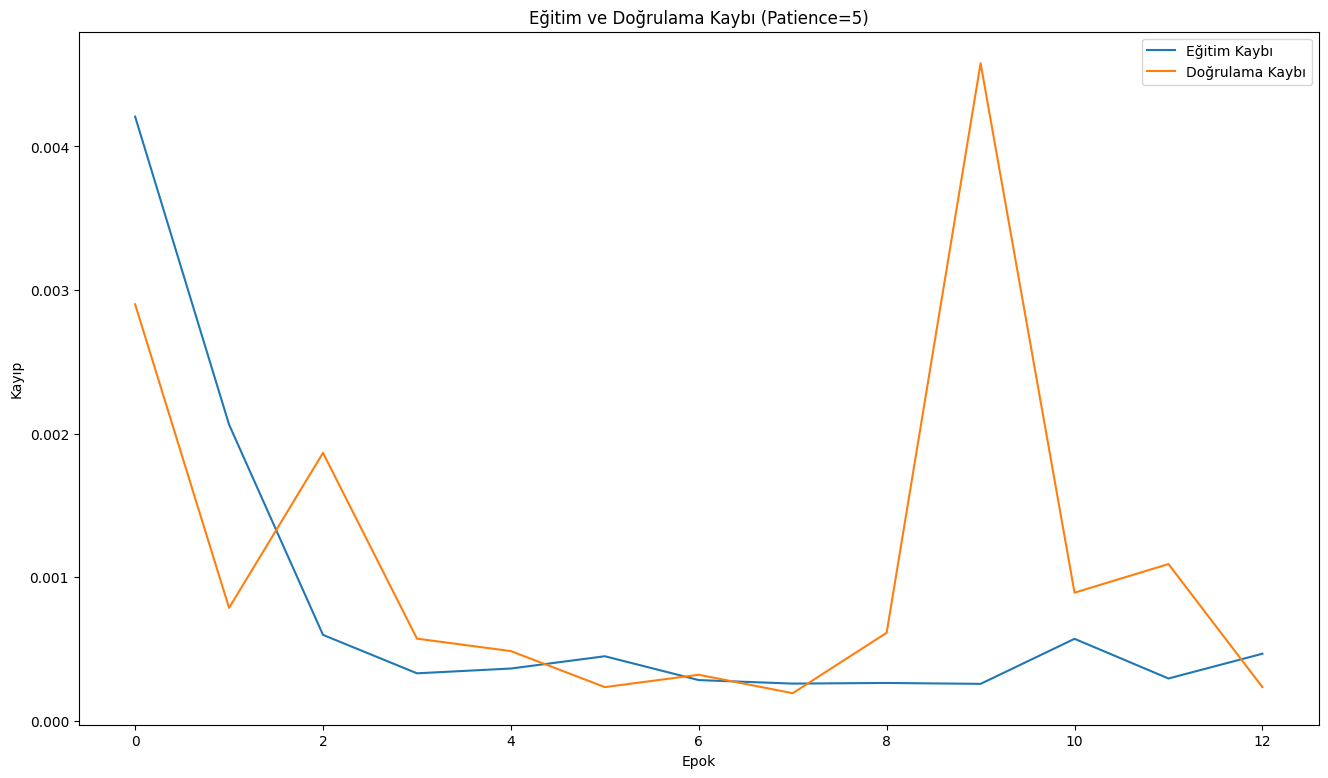

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=100,
    batch_size=64, 
    validation_data=(X_test, y_test), 
    shuffle=False, 
    callbacks=[early_stop],
    verbose=1
)

# Eğitim sürecinin kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı (Patience=5)')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# 8. Değerlendirme (Evaluation)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


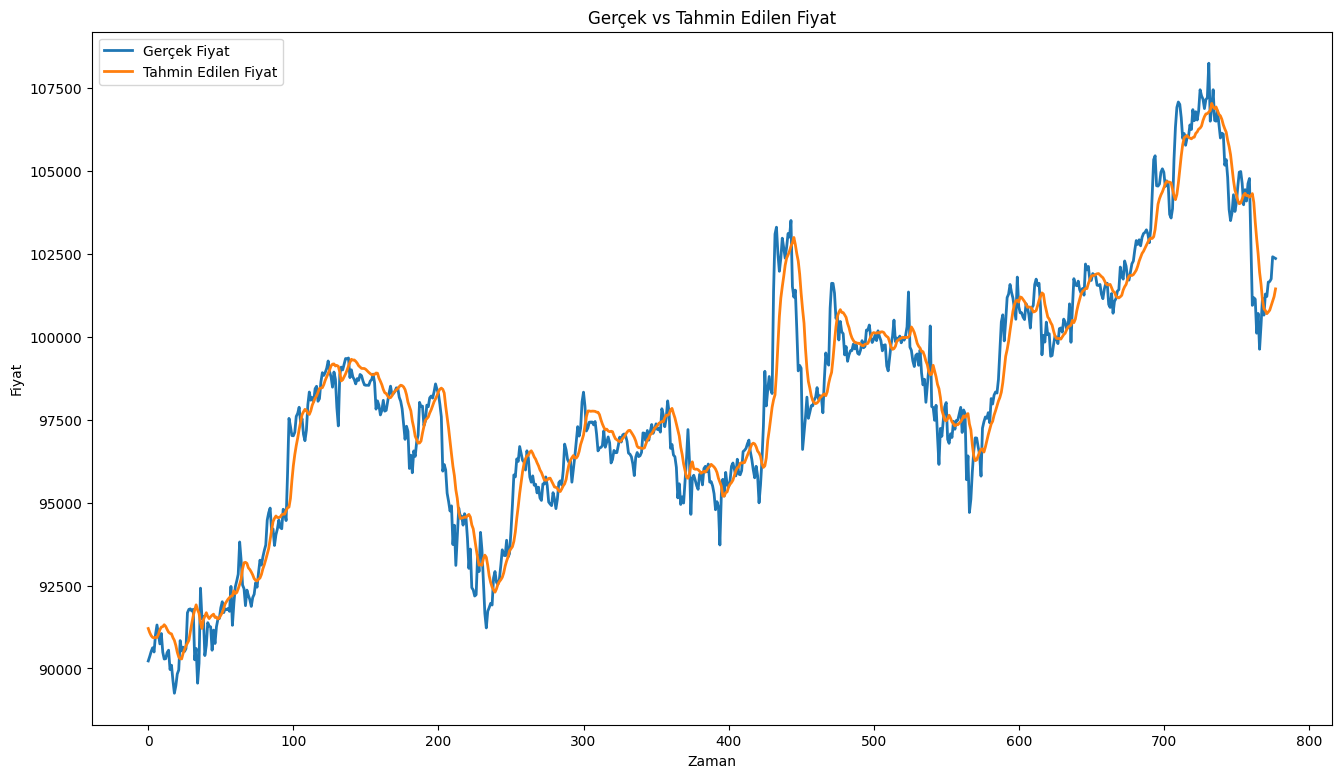

MAE: 671.8717364235218
RMSE: 934.8969169605926
MAPE: 0.6863183093695228 %


In [8]:
fiyat_tahmini = model.predict(X_test)
fiyat_tahmini = scaler.inverse_transform(fiyat_tahmini)
gercek_fiyat = scaler.inverse_transform(test_data[time_step+1:])

plt.plot(gercek_fiyat, label='Gerçek Fiyat', linewidth=2)
plt.plot(fiyat_tahmini, label='Tahmin Edilen Fiyat', linewidth=2)
plt.title('Gerçek vs Tahmin Edilen Fiyat')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

mae = mean_absolute_error(gercek_fiyat, fiyat_tahmini)
mse = mean_squared_error(gercek_fiyat, fiyat_tahmini)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((gercek_fiyat - fiyat_tahmini) / gercek_fiyat)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

# 9. Gelecek Tahminleri (Deployment/Future Predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

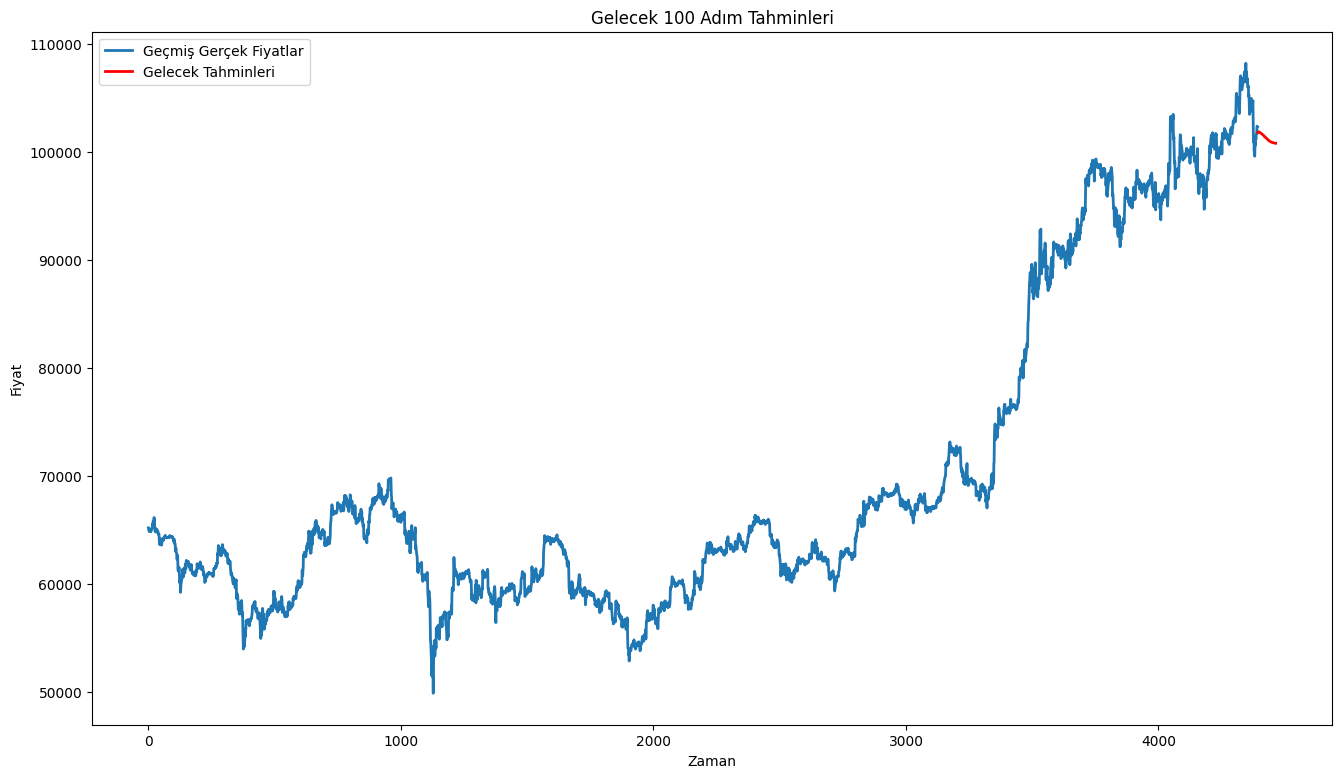

Sonraki 100 adım tahminleri: [101809.016 101847.65  101868.91  101877.65  101877.43  101871.516
 101861.125 101848.21  101832.836 101815.805 101797.86  101779.43
 101761.516 101745.19  101729.52  101712.8   101693.66  101673.1
 101653.58  101633.625 101613.05  101590.91  101567.28  101542.52
 101517.67  101491.89  101465.914 101442.664 101421.766 101403.11
 101383.695 101363.25  101341.5   101318.66  101294.9   101270.92
 101247.83  101224.336 101201.81  101179.41  101157.58  101135.65
 101114.82  101093.414 101073.5   101054.    101036.266 101019.43
 101002.305 100986.39  100971.734 100959.03  100947.14  100936.38
 100923.664 100915.16  100907.06  100898.15  100891.45  100885.38
 100878.68  100872.45  100866.74  100860.17  100852.52  100845.91
 100838.3   100831.195 100826.49  100824.02  100823.08  100822.875]


In [9]:
son_girdi = scaled_prices[-time_step:]
tahminler = []

for _ in range(72):
    tahmin = model.predict(son_girdi.reshape(1, time_step, 1))
    tahminler.append(tahmin[0, 0])
    son_girdi = np.append(son_girdi[1:], tahmin, axis=0)

tahmin_edilen_degerler = scaler.inverse_transform(np.array(tahminler).reshape(-1, 1))
orijinal_fiyatlar = scaler.inverse_transform(scaled_prices)

gelecek_adimlar = list(range(len(orijinal_fiyatlar), len(orijinal_fiyatlar) + 72))

plt.plot(orijinal_fiyatlar, label='Geçmiş Gerçek Fiyatlar', linewidth=2)
plt.plot(gelecek_adimlar, tahmin_edilen_degerler, label='Gelecek Tahminleri', color='red', linewidth=2)
plt.title('Gelecek 100 Adım Tahminleri')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

print("Sonraki 100 adım tahminleri:", tahmin_edilen_degerler.flatten())